# Convolution Neural Network

## What is new

  * Convolution Neural Network

In [1]:
%pylab inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
import tensorflow as tf
from tensorflow.python.ops.variables import Variable

Populating the interactive namespace from numpy and matplotlib


Load data from csv files.
Image is provided as space separated values in 'Image' column.

In [2]:
def make_image(xs):
    a = np.fromstring(xs, sep=' ', dtype=np.float).reshape(96, 96)
    return a / 256.0

df = pd.read_csv('../data/training.csv', converters={'Image': make_image})
df['Image'].head()

0    [[0.9296875, 0.921875, 0.92578125, 0.9296875, ...
1    [[0.85546875, 0.83984375, 0.796875, 0.765625, ...
2    [[0.5625, 0.5546875, 0.62109375, 0.703125, 0.7...
3    [[0.75390625, 0.75, 0.75390625, 0.7578125, 0.7...
4    [[0.57421875, 0.578125, 0.625, 0.765625, 0.839...
Name: Image, dtype: object

## Select only few labels

This notebook will try to predict only nose_tip labels

In [3]:
labels = ['nose_tip_x', 'nose_tip_y']
train = df[labels + ['Image']].dropna()
print('All images: %d, with labels: %d' % (len(df), len(train)))

All images: 7049, with labels: 7049


## Show image

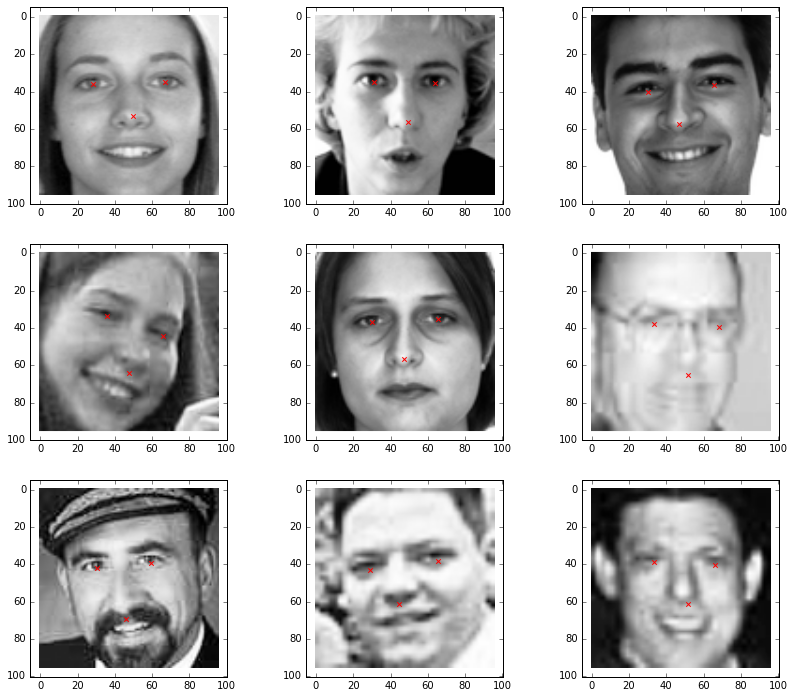

In [4]:
def show_image_with_labels(row):
    plt.imshow(row.Image, cmap='Greys_r')
    xs = [row.left_eye_center_x, row.right_eye_center_x, row.nose_tip_x]
    ys = [row.left_eye_center_y, row.right_eye_center_y, row.nose_tip_y]
    plt.scatter(x=xs, y=ys, marker='x', color='red')
    
def show_random_images(df):
    plt.gray()
    fig = plt.figure()
    n = df.shape[0]
    for i in range(9):
        fig.add_subplot(3, 3, i+1)
        index = random.randint(0, n)
        show_image_with_labels(df.iloc[index])
    plt.show()    

rcParams['figure.figsize'] = 14, 12    
show_random_images(df)

## Build tensorflow model

### Evaluate score (RMSE)

In [5]:
def mse(expected, predicted):
    ds = tf.square(expected - predicted)
    return tf.reduce_mean(ds)

### Prepare training data

Convert images read by pandas into ndarray

In [6]:
VECTOR_SIZE = 96*96
X = np.concatenate(train['Image'].apply(lambda x: np.reshape(x, VECTOR_SIZE)))
X = np.reshape(X, (len(train), VECTOR_SIZE))
print(X.shape)
Y = train[labels].as_matrix() / 48.0 - 1
print(Y.shape)

(7049, 9216)
(7049, 2)


### Helper functions for Tensorflow

In [7]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed
    
    
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#     return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


### Build model

In [9]:
L1_COUNT = 100
# Create placeholders for image data and expected point positions
x_placeholder = tf.placeholder(tf.float32, shape=[None, VECTOR_SIZE])
y_placeholder = tf.placeholder(tf.float32, shape=[None, 2])

# Build neural network
def build_model(xs):
    x_image = tf.reshape(xs, [-1, 96, 96, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable([2, 2, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable([2, 2, 64, 128])
    b_conv3 = bias_variable([128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])
    W_fc1 = weight_variable([12*12*128, 500])
    b_fc1 = bias_variable([500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)    
    # Dense layer 2
    W_fc2 = weight_variable([500, 500])
    b_fc2 = bias_variable([500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)    
    # Output layer
    W_out = weight_variable([500, 2])
    b_out = bias_variable([2])
    return tf.matmul(h_fc2, W_out) + b_out
        

# Define loss function
model = build_model(x_placeholder)
loss = mse(y_placeholder, model)

### Train 

In [ ]:
EPOCH = 1
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, train_size=0.8)
dataset = Dataset(X_train, Y_train)
with tf.Session() as session:
    start_time = time.time()
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(5e-3).minimize(loss)
    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={x_placeholder: batch_x, y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch and dataset.epoch_completed() % 100 == 0:
            score = loss.eval(feed_dict={x_placeholder: X_test, y_placeholder: Y_test})
            print('Epoch: %d, Score: %f' % (dataset.epoch_completed(), score))
            last_epoch = dataset.epoch_completed()
        break
    Y2_test = model.eval(feed_dict={x_placeholder: X_test})
    score = loss.eval(feed_dict={x_placeholder: X, y_placeholder: Y})
    print('Finished in %d seconds with score: %f' % (time.time()-start_time, score))  

Epoch: 0, Score: 413538.781250


Now when we have trained model, lets check where it thinks a nose is

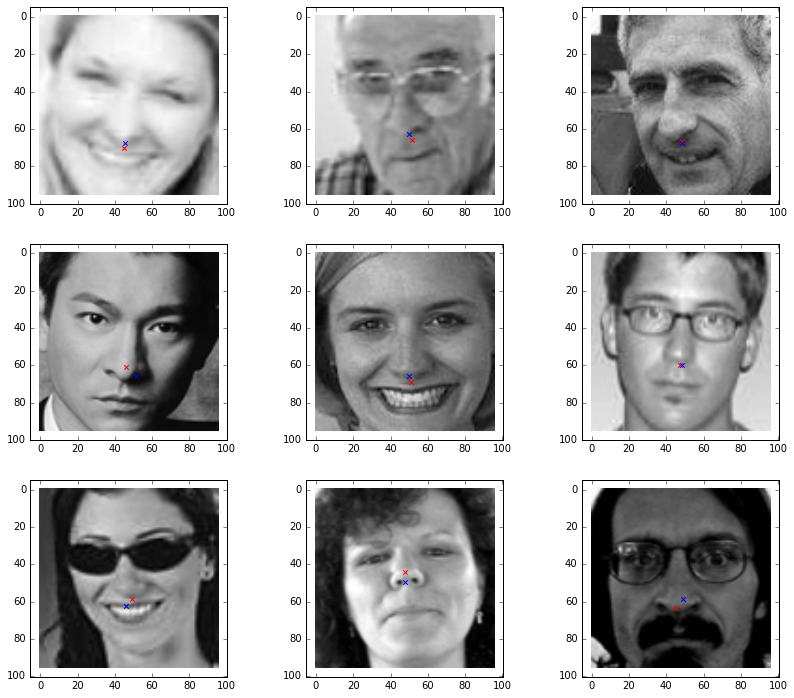

In [11]:
def show_image(image, expected, predicted):
    a = (expected + 1) * 48
    b = (predicted + 1) * 48
    plt.imshow(image)
    plt.scatter(x=a[0], y=a[1], marker='x', color='r')
    plt.scatter(x=b[0], y=b[1], marker='x', color='b')
    
def plot_random_images(images, expected, predicted):
    rcParams['figure.figsize'] = 14, 12
    plt.gray()
    fig = plt.figure()
    n = images.shape[0]
    for i in range(9):
        fig.add_subplot(3, 3, i+1)
        index = random.randint(0, n)
        image = np.reshape(images[index], (96, 96))
        show_image(image, expected[index], predicted[index])
    plt.show()    
    
    
plot_random_images(X_test, Y_test, Y2_test)  

## Remarks

  * Smaller batches reguire smaller learning rate
  * Mini batches helped with stuck at average